In [1]:
from lightkurve import search_targetpixelfile
# First we open a Target Pixel File from MAST, this one is already cached from our previous tutorial!
tpf = search_targetpixelfile('KIC 6922244', quarter=4).download()

# Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

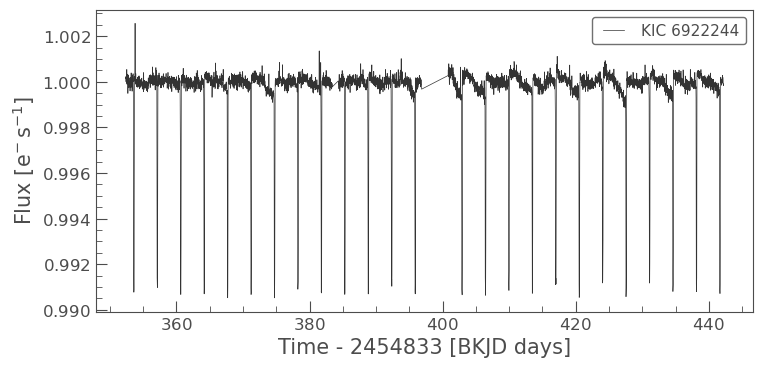

In [2]:
flat_lc = lc.flatten(window_length=401)
flat_lc.plot();

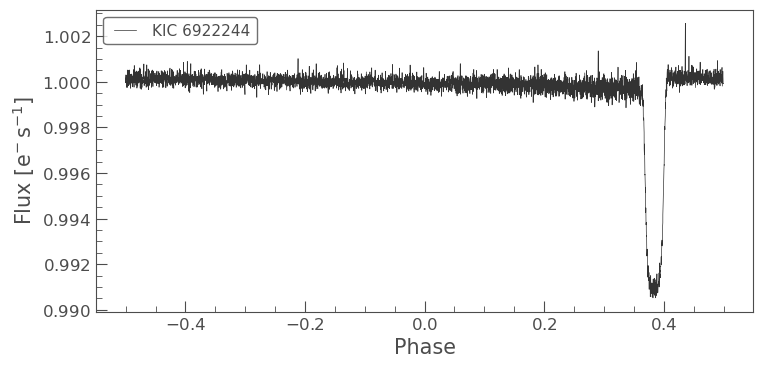

In [3]:
folded_lc = flat_lc.fold(period=3.5225)
folded_lc.plot();

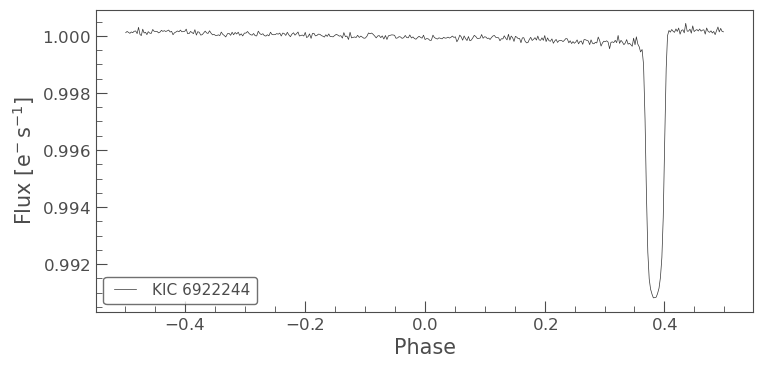

In [7]:
binned_lc = folded_lc.bin(binsize=10)
binned_lc.plot();

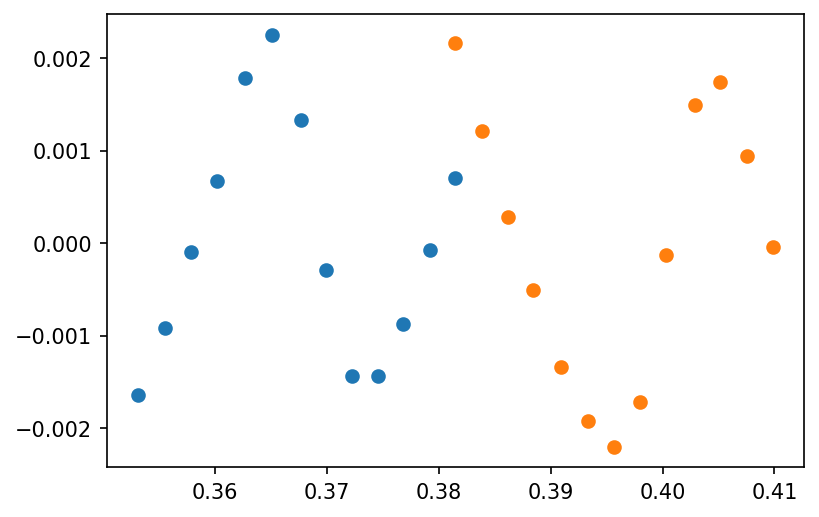

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
coordinates = list(zip(binned_lc.time, binned_lc.flux))
q1_flux = np.percentile(binned_lc.flux, 10)
absolute_minimum = min(coordinates, key = lambda t: t[1])
absolute_minimum_index, leftmost_index, rightmost_index = (coordinates.index(absolute_minimum),)*3
while coordinates[leftmost_index][1] <= q1_flux:
    leftmost_index -= 1
    rightmost_index +=1 # assume symmetry to get idealized geometry
isolated_curve = [coordinate for index, coordinate in enumerate(coordinates) if leftmost_index <=
                  index <= rightmost_index]
left_points = [coordinate for coordinate in isolated_curve 
               if coordinate[0] <= absolute_minimum[0]]
right_points = [coordinate for coordinate in isolated_curve 
                if coordinate[0] >= absolute_minimum[0]]
x_left, y_left = zip(*left_points)
x_right, y_right = zip(*right_points)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_left, y_left)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x_right, y_right)
left_residuals, right_residuals = [], []
for time, flux in left_points:
    flux_hat =  slope * time + intercept
    residual = (time, flux - flux_hat)
    left_residuals.append(residual)
for time, flux in right_points:
    flux_hat = slope2 * time + intercept2
    residual = (time, flux - flux_hat)
    right_residuals.append(residual)
plt.figure(dpi = 150)
plt.scatter(*zip(*left_residuals))
plt.scatter(*zip(*right_residuals))